In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import time

In [21]:
def succ_prob_calc(B_orig, logicals, s_nodes, loss_inds):
    B = B_orig.copy()
    s_nodes_set = set(np.copy(s_nodes))

    Ns_remain = len(s_nodes_set)
    q_remain = list(set(B.nodes())-s_nodes_set)
    node_list = list(s_nodes_set) + q_remain
    adj_mat_new = nx.to_numpy_array(B, nodelist = node_list)
    Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:]

    logic_succ = True
    for q in loss_inds:
        if logicals.ndim == 1:
            if logicals[q]>0:            
                st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                if len(st_ind)>0:
                    logicals = (logicals+Sx_mat[st_ind[0],:]) % 2
                else:
                    logic_succ = False
                    break
        else:
            for i_log in range(np.size(logicals,0)):
                if logicals[i_log,q]>0:            
                    st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                    if len(st_ind)>0:
                        logicals[i_log,:] = (logicals[i_log,:]+Sx_mat[st_ind[0],:]) % 2
                    else:
                        logic_succ = False
                        break
            if not logic_succ:
                break
            
        if q in B:
            sq = [n for n in B.neighbors(q)]
            if len(sq)==1:
                B.remove_nodes_from(sq)
                s_nodes_set -= set(sq)
            elif len(sq)>1:
                double_edgs = []
                for i in range(len(sq)-1):
                    n0 = set(B.neighbors(sq[i]))
                    n1 = set(B.neighbors(sq[i+1]))
                    rep_qs = n0.intersection(n1)
                    q0 = list(set(n0)-rep_qs)
                    q1 = list(set(n1)-rep_qs)
                    double_edgs += [(sq[i], e) for e in q0]
                    double_edgs += [(sq[i], e) for e in q1]
                G = nx.Graph()
                G.add_nodes_from(sq[:-1])
                G.add_edges_from(double_edgs)
                sq_remain = list(s_nodes_set-set(sq))
                for s in sq_remain:
                    G.add_edges_from([(s, e) for e in B.neighbors(s)])
                B = G
                s_nodes_set -= {sq[-1]}

            Ns_remain = len(s_nodes_set)
            if Ns_remain> 0:
                q_remain = list(set(B.nodes())-s_nodes_set)
                node_list = list(s_nodes_set) + q_remain
                adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
                Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
                Sx_mat = np.zeros((Ns_remain,N))
                Sx_mat[:,q_remain] = Sx_red
            else:
                Sx_mat = []
                break

    if logicals.ndim == 1:
        logic_sum = np.sum(logicals)> 0
    else:
        logic_sum = np.sum(np.sum(logicals,axis=1))>1
    succ_fail = 0
    if Ns_remain > 0 and logic_sum and logic_succ:
        succ_fail = 1

    return succ_fail

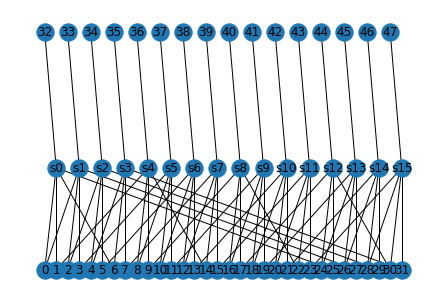

KeyboardInterrupt: 

In [23]:
r1 = 4
r2 = 4

# in layer stabilizer group
Sx_mat = np.zeros((r1*r2,2*r1*r2),dtype=int)
for i_y in range(r2):
    for i_x in range(r1):
        Sx_mat[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sx_mat[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sx_mat[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
        Sx_mat[i_y*r1 + i_x, 2*(((i_y-1)%r2)*r1+i_x)+1] = 1
        # pos["s%d" % (i_y*r1 + i_x)] = (i_x-0.1,i_y-0.1)
        # pos[2*(i_y*r1 + i_x)] = (i_x+0.5,i_y)
        # pos[2*(i_y*r1 + i_x)+1] = (i_x,i_y+0.5)
        # pos[2*(i_y*r1+(i_x-1)%r1 )] = (i_x-0.5,i_y)
        # pos[ 2*(((i_y-1)%r2)*r1+i_x)+1] = (i_x,i_y-0.5)

Nq_l = np.size(Sx_mat,1) # number of data qubits per layer
Ns_l = np.size(Sx_mat,0) # number of stabilizers per layer


Nl_list = np.arange(1,4)
p_list = np.linspace(0.01,0.4,20)
Nrep = 1000
succ_prob = np.zeros((len(p_list),len(Nl_list)))

for i_L, Nl in enumerate(Nl_list):
    tic = time.time()
    # Nl = 3 # number of layers in foliated code
    N = Nl*(Nq_l+Ns_l) # number of data qubits
    Ns = Nl*Ns_l # number of stabilizers
    B_orig = nx.Graph()
    B_orig.add_nodes_from(np.arange(N))
    s_nodes = ["s%d" % s for s in np.arange(Ns)]
    B_orig.add_nodes_from(s_nodes)
    for row in range(Ns_l):
        qs = np.argwhere(Sx_mat[row,:]>0)[:,0]
        for i_l in range(Nl):
            B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+row), i_l*(Nq_l+Ns_l)+q) for q in qs])
    for i_l in range(Nl):
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), i_l*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), ((i_l-1)%Nl)*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])

    # pos = graphviz_layout(B_orig, prog="dot")
    pos = dict()
    for q in range(N):
        x_l = q%(Nq_l+Ns_l)
        x = x_l%r1
        y = int(x_l/r1)
        z = int(q/(Nq_l+Ns_l))
        if x_l >= Nq_l:
            pos[q] = (2*(x_l-Nq_l/2)-Nq_l,z+0.7)
            # pos[q] = (x,y,z)
        else:
            pos[q] = (x_l,z)
    for sq in range(Ns):
        x_l = (sq% Ns_l)
        x = x_l%r1
        y = int(x_l/r1)
        z = int(sq/Ns_l)
        pos["s%d" % sq] = (2*x_l+1,z+0.3)

    # pos  = nx.spring_layout(B_orig, k = 0.5)
    nx.draw(B_orig, pos,  with_labels=True)
    plt.show()

    logicals_l = np.zeros((2,2*r1*r2))
    logicals_l[0,1:2*r1:2] = np.ones(r1) 
    logicals_l[1,0:2*r1*r2:2*r1] = np.ones(r2) 

    logicals = np.zeros((3,N))
    for i_l in range(Nl):
        logicals[:2,i_l*(Nq_l+Ns_l):i_l*(Nq_l+Ns_l)+Nq_l] = logicals_l

    for i_p, p in enumerate(p_list):
        for i_rep in range(Nrep):
            loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
            succ_prob[i_p] += succ_prob_calc(B_orig, logicals, s_nodes, loss_inds)
    toc = time.time()
    print("finished L = %d in %.1f secs" % (Nl,toc-tic))

succ_prob /= Nrep

## single layer